## Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torch.nn as nn
from transformers import BertModel
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, classification_report, confusion_matrix


## Data Preprocessing

In [2]:
df=pd.read_excel('AI Agents Evaluation Dataset.xlsx')
df.head()

,prompt_id,prompt,agent_id,response,reference_answer,instruction_score,hallucination_score,assumption_score,coherence_score,accuracy_score,completeness_score,overall_score
0,1,In what year did the Treaty of Versailles end ...,1,"1919, Article 231 (War Guilt Clause).",Treaty signed in 1919 (WWI ended 1918). Articl...,1.0,0.0,0.0,1.0,1.0,1.0,5.0
1,2,Explain why the Library of Alexandria was burn...,1,Julius Caesar accidentally burned part of the ...,Caesar didn’t intentionally torch the Library;...,1.0,0.0,0.0,1.0,1.0,1.0,5.0
2,3,"Who invented the TCP/IP protocol in 1969, and ...",1,Vint Cerf and Robert Kahn; TCP/IP supported in...,TCP/IP was designed by Vint Cerf and Bob Kahn ...,1.0,0.0,0.0,1.0,1.0,1.0,5.0
3,4,"If a bat and ball cost $1.10 total, and the ba...",1,"Ball = $0.05, Bat = $1.05.",Let ball cost x and bat cost x+1.00; x+(x+1.00...,1.0,0.0,0.0,1.0,1.0,1.0,5.0
4,5,"In a room with 23 people, what is the probabil...",1,Probability ≈ 50.73%. Reasoning: compute the c...,About 50.7%; assuming 365 equally likely birth...,1.0,0.0,0.0,1.0,1.0,1.0,5.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   prompt_id            240 non-null    int64  
 1   prompt               240 non-null    object 
 2   agent_id             240 non-null    int64  
 3   response             240 non-null    object 
 4   reference_answer     240 non-null    object 
 5   instruction_score    240 non-null    float64
 6   hallucination_score  240 non-null    float64
 7   assumption_score     240 non-null    float64
 8   coherence_score      240 non-null    float64
 9   accuracy_score       240 non-null    float64
 10  completeness_score   240 non-null    float64
 11  overall_score        240 non-null    float64
dtypes: float64(7), int64(2), object(3)
memory usage: 22.6+ KB


In [6]:
def make_bert_input(row):
  return (
      f"Prompt: {row['prompt']} [SEP] "
      f"Response: {row['response']} [SEP] "
      f"Reference: {row['reference_answer']}"
  )

df['bert_input']=df.apply(make_bert_input,axis=1)

In [8]:
scoring_cols = [
    "instruction_score", "hallucination_score", "assumption_score",
    "coherence_score", "accuracy_score", "completeness_score", "overall_score"
]
for col in scoring_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)

In [9]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['agent_id'], shuffle=True
)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 192, Test size: 48


In [ ]:
class AgenticEvalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512, scoring_cols=None):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.scoring_cols = scoring_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["bert_input"]
        enc = self.tokenizer(
            text, truncation=True, padding='max_length',
            max_length=self.max_length, return_tensors='pt'
        )

        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0)
        }
        labels = row[self.scoring_cols].values.astype(float)
        item["labels"] = torch.tensor(labels, dtype=torch.float)
        return item

# ==== Initialize Tokenizer & DataLoader ====
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_ds = AgenticEvalDataset(train_df, tokenizer, scoring_cols=scoring_cols)
test_ds = AgenticEvalDataset(test_df, tokenizer, scoring_cols=scoring_cols)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

print(f"✅ Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

## BERT Model Architecture

In [11]:
class MultiHeadBERT(nn.Module):
    def __init__(self, out_dim=7):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.head = nn.Linear(self.bert.config.hidden_size, out_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = outputs.pooler_output
        return self.head(cls)


## Fine-tuning the Model

In [ ]:
def train_model(model, train_loader, num_epochs=10):
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Track losses
    losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Training loss {avg_loss:.4f}")

    return losses

model = MultiHeadBERT(out_dim=len(scoring_cols))
losses = train_model(model, train_loader, num_epochs=10)


# Print training summary
print(f"\nTraining Summary:")
print(f"Final Loss: {losses[-1]:.4f}")
print(f"Minimum Loss: {min(losses):.4f} (Epoch {np.argmin(losses) + 1})")
print(f"Loss Reduction: {((losses[0] - losses[-1]) / losses[0] * 100):.2f}%")

## Training loss curve

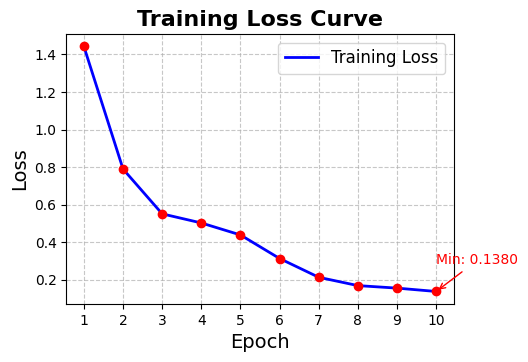

In [18]:
def plot_loss_curve(losses):
    plt.figure(figsize=(5, 3.5))
    plt.plot(range(1, len(losses) + 1), losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(range(1, len(losses) + 1), losses, 'ro', markersize=6)

    plt.title('Training Loss Curve', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.xticks(range(1, len(losses) + 1))


    min_idx = np.argmin(losses)
    plt.annotate(f'Min: {losses[min_idx]:.4f}',
                 xy=(min_idx+1, losses[min_idx]),
                 xytext=(min_idx+1, losses[min_idx] + max(losses)*0.1),
                 arrowprops=dict(arrowstyle='->', color='red'),
                 fontsize=10, color='red')
    plt.show()

# Plot the loss curve
plot_loss_curve(losses)

## Evaluating the model performance

In [ ]:

def evaluate_model_outputs(model, dataloader, device, scoring_cols, threshold=0.5):
    """Evaluates model on the given dataloader, computes metrics per dimension."""
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask)  # (batch, num_dim)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(labels.cpu().numpy())
    # Concatenate all batches
    preds = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    results = {}
    for i, col in enumerate(scoring_cols):
        # If you trained for 0-1 regression, threshold for binary metrics
        preds_binary = (preds[:, i] > threshold).astype(int)
        targets_binary = (targets[:, i] > threshold).astype(int)

        mse = mean_squared_error(targets[:, i], preds[:, i])
        acc = accuracy_score(targets_binary, preds_binary)
        f1 = f1_score(targets_binary, preds_binary, zero_division=0)
        report = classification_report(targets_binary, preds_binary, zero_division=0, output_dict=True)
        cm = confusion_matrix(targets_binary, preds_binary)

        results[col] = {
            'mse': mse,
            'accuracy': acc,
            'f1_score': f1,
            'classification_report': report,
            'confusion_matrix': cm.tolist()
        }
    # Optionally, compute overall average accuracy/MSE/F1
    results['avg_accuracy'] = np.mean([results[col]['accuracy'] for col in scoring_cols])
    results['avg_mse'] = np.mean([results[col]['mse'] for col in scoring_cols])
    results['avg_f1'] = np.mean([results[col]['f1_score'] for col in scoring_cols])
    return results

# ==== Usage Example ====
# scoring_cols = ["instruction_score", "hallucination_score", ...]
metrics = evaluate_model_outputs(model, test_loader, device, scoring_cols)
# Print summary
for dim in scoring_cols:
    print(f"{dim:20s} | Acc: {metrics[dim]['accuracy']:.3f} | F1: {metrics[dim]['f1_score']:.3f} | MSE: {metrics[dim]['mse']:.4f}")

print(f"Average Accuracy: {metrics['avg_accuracy']:.3f}")
print(f"Average F1      : {metrics['avg_f1']:.3f}")
print(f"Average MSE     : {metrics['avg_mse']:.4f}")


instruction_score    | Acc: 0.833 | F1: 0.879 | MSE: 0.0943
hallucination_score  | Acc: 0.917 | F1: 0.750 | MSE: 0.0986
assumption_score     | Acc: 0.833 | F1: 0.692 | MSE: 0.0772
coherence_score      | Acc: 0.792 | F1: 0.881 | MSE: 0.1461
accuracy_score       | Acc: 0.792 | F1: 0.848 | MSE: 0.1169
completeness_score   | Acc: 0.792 | F1: 0.839 | MSE: 0.0787
overall_score        | Acc: 1.000 | F1: 1.000 | MSE: 1.4591
Average Accuracy: 0.851
Average F1      : 0.841
Average MSE     : 0.2959


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
# ==== Plotting (Accuracy & F1 only) ====
accuracies = [metrics[col]['accuracy'] for col in scoring_cols]
f1_scores = [metrics[col]['f1_score'] for col in scoring_cols]

x = np.arange(len(scoring_cols))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

ax.set_ylabel("Scores")
ax.set_title("Accuracy and F1 Score by Metric")
ax.set_xticks(x)
ax.set_xticklabels(scoring_cols, rotation=30, ha="right")
ax.set_ylim(0, 1.1)
ax.legend()

# Display values on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

## Saving the model

In [ ]:
MODEL_PATH = 'trained_agentic_evaluator.pt'
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model weights saved at: {MODEL_PATH}")

Model weights saved at: trained_agentic_evaluator.pt


## Loading and Testing the loaded model

In [ ]:
loaded_model = MultiHeadBERT(out_dim=len(scoring_cols))
# Load saved weights
loaded_model.load_state_dict(torch.load("trained_agentic_evaluator.pt", map_location="cpu"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

MultiHeadBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [ ]:
metrics = evaluate_model_outputs(loaded_model, test_loader, device, scoring_cols)

for dim in scoring_cols:
    print(f"{dim:20s} | Acc: {metrics[dim]['accuracy']:.3f} | F1: {metrics[dim]['f1_score']:.3f} | MSE: {metrics[dim]['mse']:.4f}")

print(f"Average Accuracy: {metrics['avg_accuracy']:.3f}")
print(f"Average F1      : {metrics['avg_f1']:.3f}")
print(f"Average MSE     : {metrics['avg_mse']:.4f}")

instruction_score    | Acc: 0.833 | F1: 0.879 | MSE: 0.0943
hallucination_score  | Acc: 0.917 | F1: 0.750 | MSE: 0.0986
assumption_score     | Acc: 0.833 | F1: 0.692 | MSE: 0.0772
coherence_score      | Acc: 0.792 | F1: 0.881 | MSE: 0.1461
accuracy_score       | Acc: 0.792 | F1: 0.848 | MSE: 0.1169
completeness_score   | Acc: 0.792 | F1: 0.839 | MSE: 0.0787
overall_score        | Acc: 1.000 | F1: 1.000 | MSE: 1.4591
Average Accuracy: 0.851
Average F1      : 0.841
Average MSE     : 0.2959


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
def predict(model,tokenizer,text,scoring_cols,device,threshold=0.5):
    model.eval()
    enc = tokenizer(
        text, truncation=True, padding='max_length',
        max_length=512, return_tensors='pt'
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
    outputs = model(input_ids, attention_mask)
    result=outputs.to(device)
    return result


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text="Prompt: In what year did the Treaty of Versailles end World War I, and which specific clause led to hyperinflation in Germany? [SEP] Response: 1919, Article 231 (War Guilt Clause). [SEP] Reference: Treaty signed in 1919 (WWI ended 1918). Article 231 (war guilt clause) and reparations led to hyperinflation."
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scoring_cols = ["instruction_score", "hallucination_score", "assumption_score", "coherence_score", "accuracy_score", "completeness_score", "overall_score"]
result=predict(loaded_model,tokenizer,text,scoring_cols=scoring_cols,device=device)
print(result)

tensor([[1.0230e+00, 5.8761e-04, 3.7546e-02, 1.0590e+00, 9.6791e-01, 1.0020e+00,
         4.8699e+00]], device='cuda:0', grad_fn=<AddmmBackward0>)
